In [1]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.9 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import joblib

from sklearn import feature_extraction, tree, svm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from heapq import nlargest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/Masters_Team_Project_Final/Binary_Classification/Journal_500Dataset.xlsx")
df.head()

,text_cleaned,er_strat,adaptive
0,Missing Mum and Dad. Overwhelmed with everythi...,NaN,NaN
1,"I feel a little tired, but satisfied at the en...",NaN,NaN
2,My pain sits in my heart and is a solid heavy ...,Cognitive Change,adaptive
3,I’m feeling more in control of my grieving. I’...,Situation Modification,adaptive
4,Just finished‘soothing & relaxing’ session whe...,Response Modulation,adaptive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_cleaned  500 non-null    object
 1   er_strat      480 non-null    object
 2   adaptive      429 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [ ]:
# Remove any spaces from the 'er_strat' column values
df['er_strat'] = df['er_strat'].str.strip()

# Standardize the format by:
# - Splitting the values into a list using ', ' as a separator
# - Keeping NaN values and entries explicitly labeled as 'none' unchanged
df['er_strat'] = df['er_strat'].apply(
    lambda x: ', '.join(sorted(x.split(', '))) if pd.notnull(x) and x.lower() != 'none' else x
)

# Ensure consistent representation by replacing lowercase 'none' with 'None'
df['er_strat'] = df['er_strat'].replace('none', 'None')

# Count the occurrences of each unique category combination
df['er_strat'].value_counts()

,count
er_strat,
Attentional Deployment,142
Cognitive Change,113
Response Modulation,63
None,58
Situation Selection,20
Situation Modification,15
"Cognitive Change, Response Modulation",14
"Cognitive Change, Situation Selection",11
"Attentional Deployment, Situation Modification",7


In [ ]:
# Count the number of NaN (missing) values in the 'er_strat' column
num_nan = df['er_strat'].isna().sum()

# Print the count of NaN values for reference
print(f"Number of NaN values in 'er_strat': {num_nan}")

# Remove rows where 'er_strat' is NaN to ensure only valid data remains
df = df.dropna(subset=['er_strat'])

Number of NaN values in 'er_strat': 20


In [ ]:
# Select and display rows where 'er_strat' is NaN (missing values)
nan_rows = df[df['er_strat'].isna()]
print(nan_rows)

# Print the data types of all columns in the DataFrame
print(df.dtypes)

Empty DataFrame
Columns: [text_cleaned, er_strat, adaptive]
Index: []
text_cleaned    object
er_strat        object
adaptive        object
dtype: object


In [ ]:
# Extract unique categories, excluding NaN
categories = set()
df['er_strat'].dropna().apply(lambda x: categories.update(x.split(', ')))

# Convert the set of categories into a sorted list
categories = sorted(categories)
print(categories)

# Create binary columns for each category
for category in categories:
    df[category] = df['er_strat'].apply(
        lambda x: 1 if pd.notnull(x) and category in x.split(', ') else 0
    )

# Create the 'None' column to flag NaN values
df['None'] = df['er_strat'].apply(lambda x: 1 if pd.isna(x) else 0)

# Display the updated DataFrame
df.head()

['Attentional Deployment', 'Cognitive Change', 'None', 'Response Modulation', 'Situation Modification', 'Situation Selection']


,text_cleaned,er_strat,adaptive,Attentional Deployment,Cognitive Change,None,Response Modulation,Situation Modification,Situation Selection
2,My pain sits in my heart and is a solid heavy ...,Cognitive Change,adaptive,0,1,0,0,0,0
3,I’m feeling more in control of my grieving. I’...,Situation Modification,adaptive,0,0,0,0,1,0
4,Just finished‘soothing & relaxing’ session whe...,Response Modulation,adaptive,0,0,0,1,0,0
5,Tired and in strange pain both physically and ...,None,none,0,0,0,0,0,0
6,I don’t want to be close to people or dogs the...,Situation Selection,maladaptive,0,0,0,0,0,1



=== Evaluating LogisticRegression ===

DETAILED EVALUATION REPORT FOR LogisticRegression

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6319     0.4167     0.0980     0.1587    
Cognitive Change          0.6528     1.0000     0.1071     0.1935    
Response Modulation       0.8125     0.0000     0.0000     0.0000    
Situation Modification    0.9097     0.0000     0.0000     0.0000    
Situation Selection       0.9028     0.0000     0.0000     0.0000    
None                      0.8750     1.0000     0.0526     0.1000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.0556
Macro-Averaged Precision: 0.0754
Macro-Averaged Recall: 0.0754
Macro-Averaged F1-Score: 0.0754


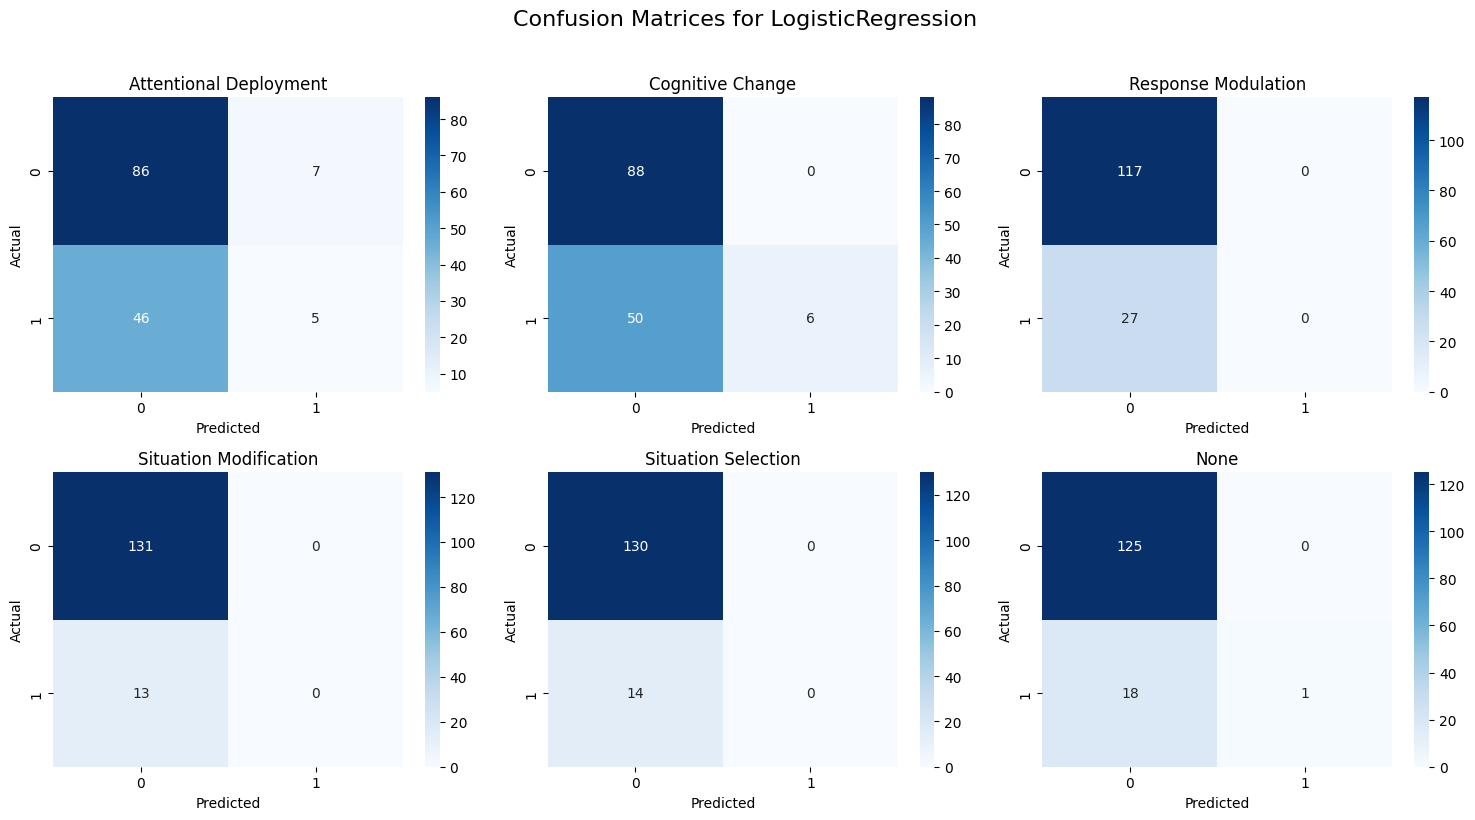


=== Evaluating RandomForest ===

DETAILED EVALUATION REPORT FOR RandomForestClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6458     0.5000     0.0980     0.1639    
Cognitive Change          0.6875     0.8667     0.2321     0.3662    
Response Modulation       0.8056     0.0000     0.0000     0.0000    
Situation Modification    0.9097     0.0000     0.0000     0.0000    
Situation Selection       0.9028     0.0000     0.0000     0.0000    
None                      0.9097     0.7143     0.5263     0.6061    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.1250
Macro-Averaged Precision: 0.1894
Macro-Averaged Recall: 0.1894
Macro-Averaged F1-Score: 0.1894


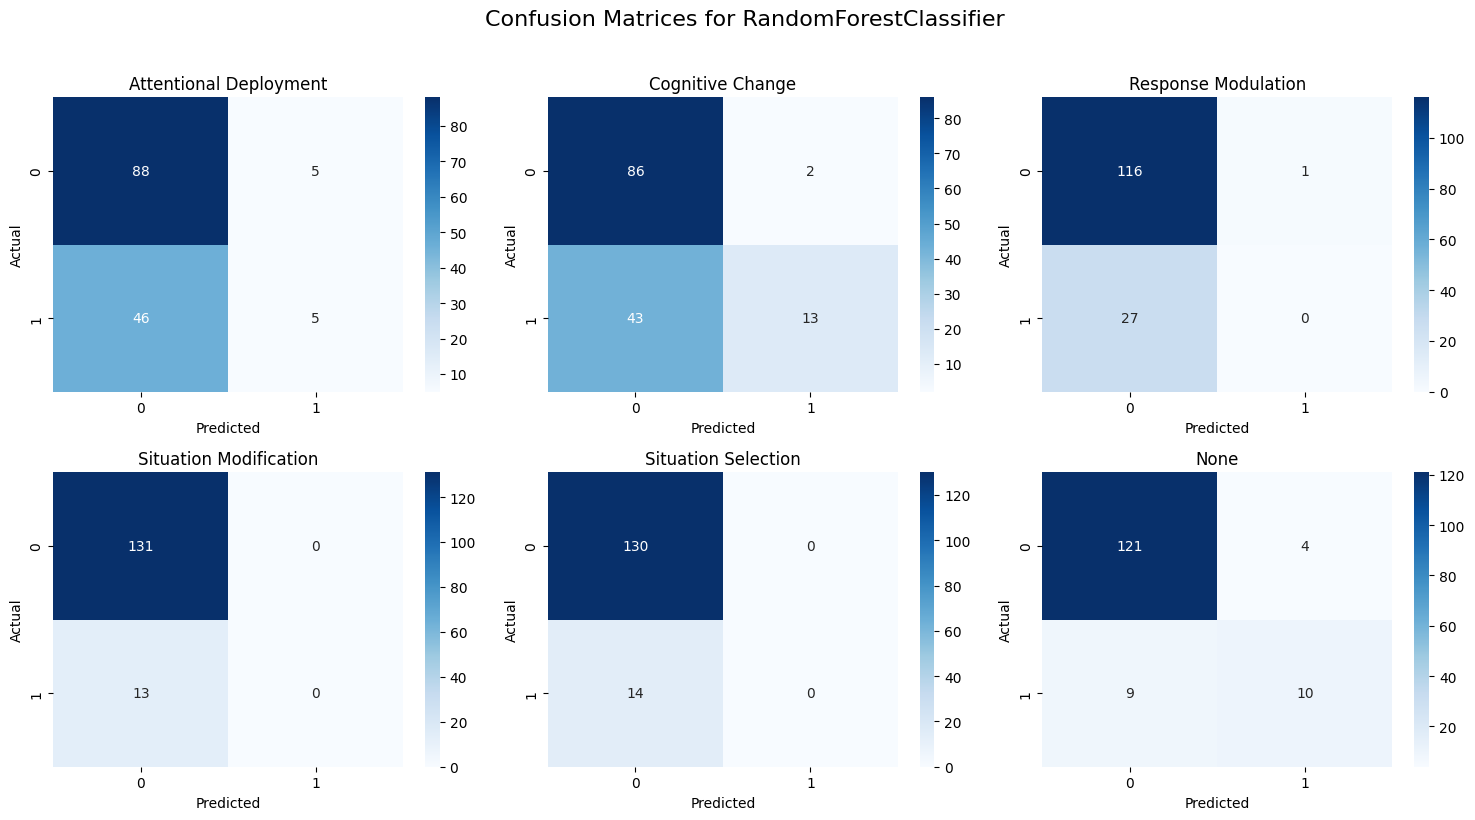


=== Evaluating SVM ===

DETAILED EVALUATION REPORT FOR SVC

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6389     0.4828     0.2745     0.3500    
Cognitive Change          0.7014     0.7826     0.3214     0.4557    
Response Modulation       0.8056     0.0000     0.0000     0.0000    
Situation Modification    0.9097     0.0000     0.0000     0.0000    
Situation Selection       0.9028     0.0000     0.0000     0.0000    
None                      0.8819     1.0000     0.1053     0.1905    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.1597
Macro-Averaged Precision: 0.1660
Macro-Averaged Recall: 0.1660
Macro-Averaged F1-Score: 0.1660


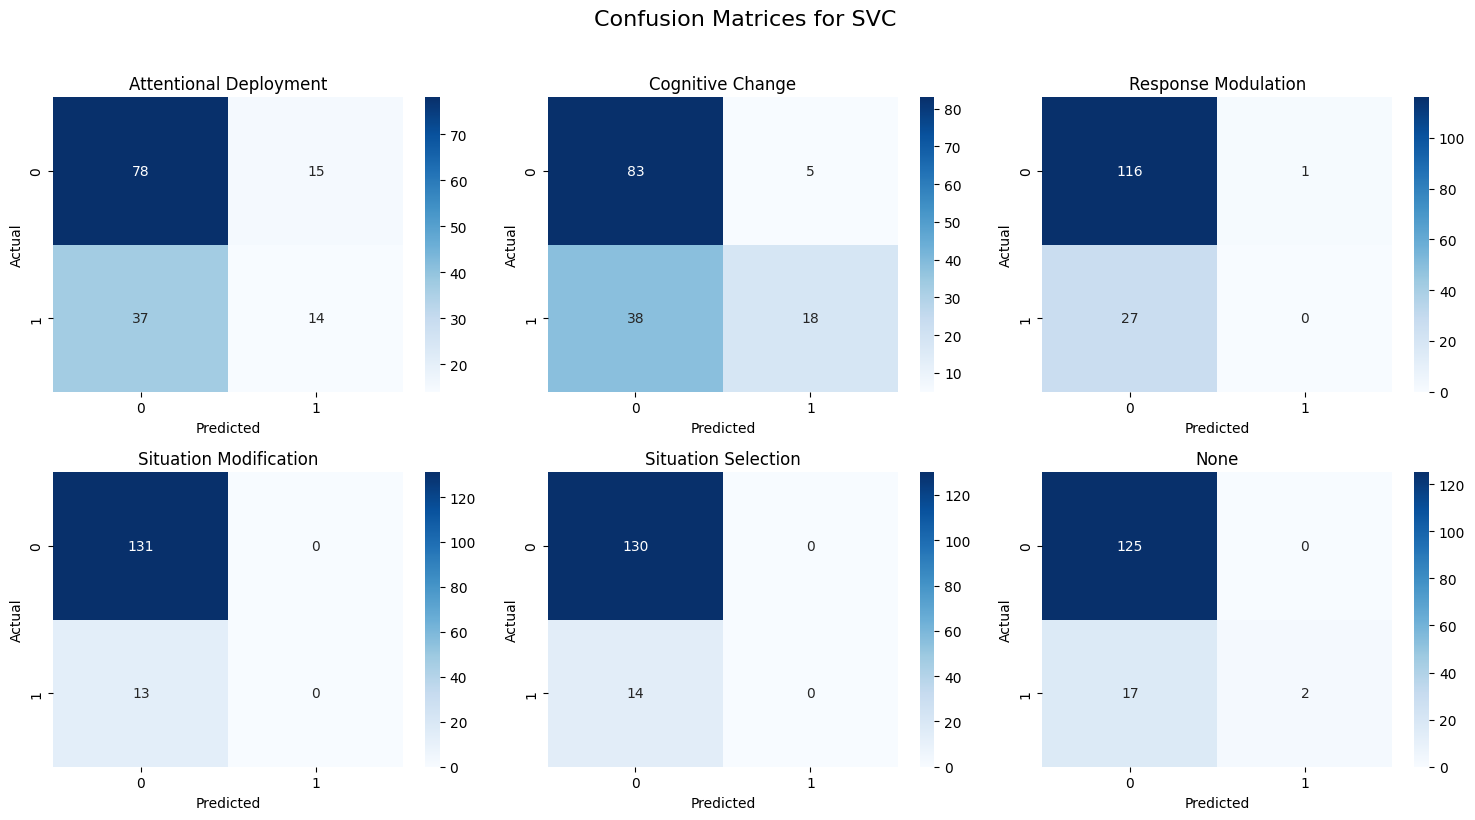


=== Evaluating AdaBoost ===

DETAILED EVALUATION REPORT FOR AdaBoostClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6389     0.4800     0.2353     0.3158    
Cognitive Change          0.6944     0.6765     0.4107     0.5111    
Response Modulation       0.7847     0.0000     0.0000     0.0000    
Situation Modification    0.8958     0.2500     0.0769     0.1176    
Situation Selection       0.8958     0.0000     0.0000     0.0000    
None                      0.9167     0.7692     0.5263     0.6250    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.2014
Macro-Averaged Precision: 0.2616
Macro-Averaged Recall: 0.2616
Macro-Averaged F1-Score: 0.2616


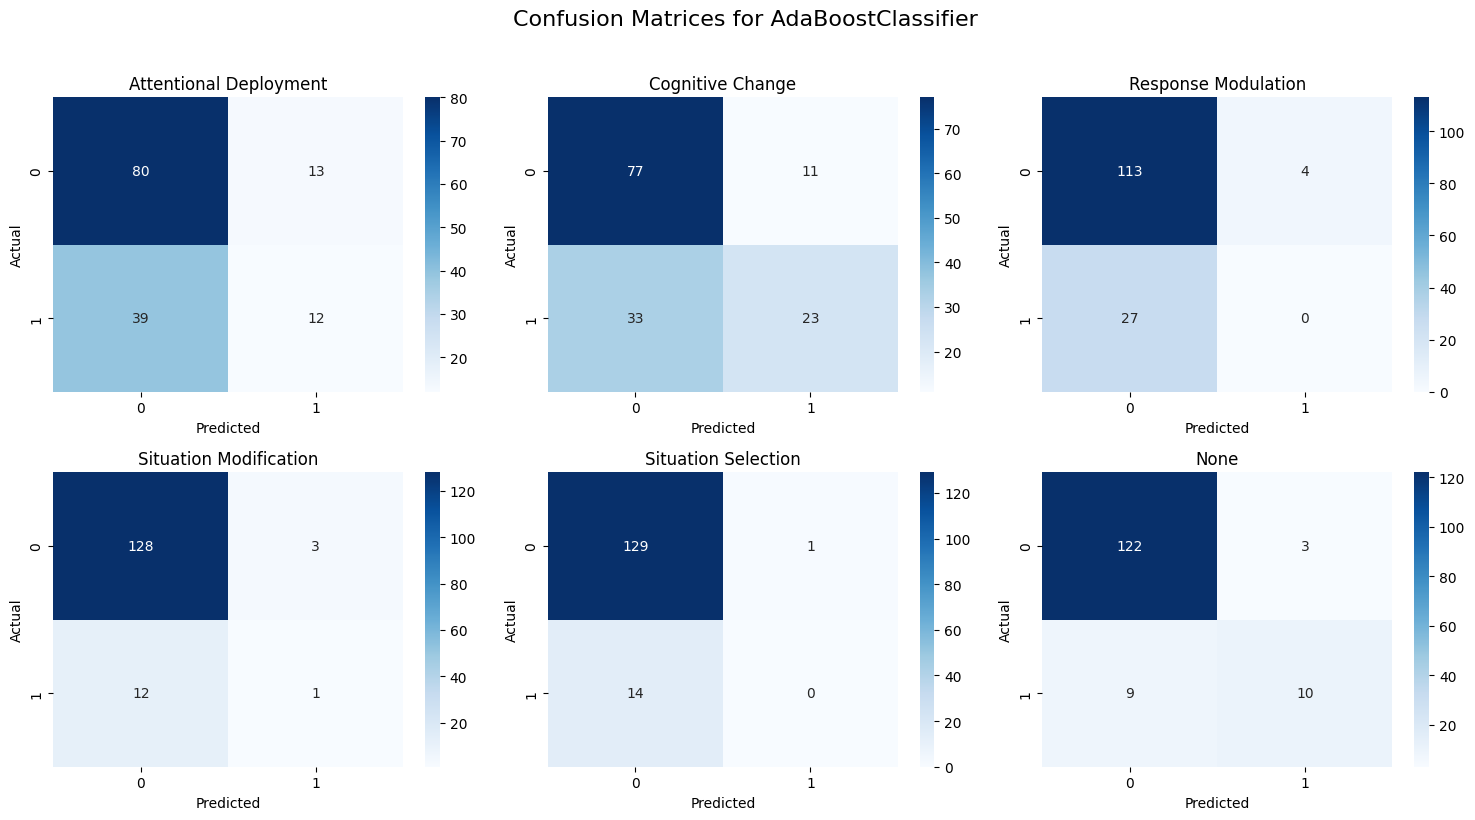


=== Evaluating NaiveBayes ===

DETAILED EVALUATION REPORT FOR MultinomialNB

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6528     1.0000     0.0196     0.0385    
Cognitive Change          0.6111     0.0000     0.0000     0.0000    
Response Modulation       0.8125     0.0000     0.0000     0.0000    
Situation Modification    0.9097     0.0000     0.0000     0.0000    
Situation Selection       0.9028     0.0000     0.0000     0.0000    
None                      0.8681     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.0000
Macro-Averaged Precision: 0.0064
Macro-Averaged Recall: 0.0064
Macro-Averaged F1-Score: 0.0064


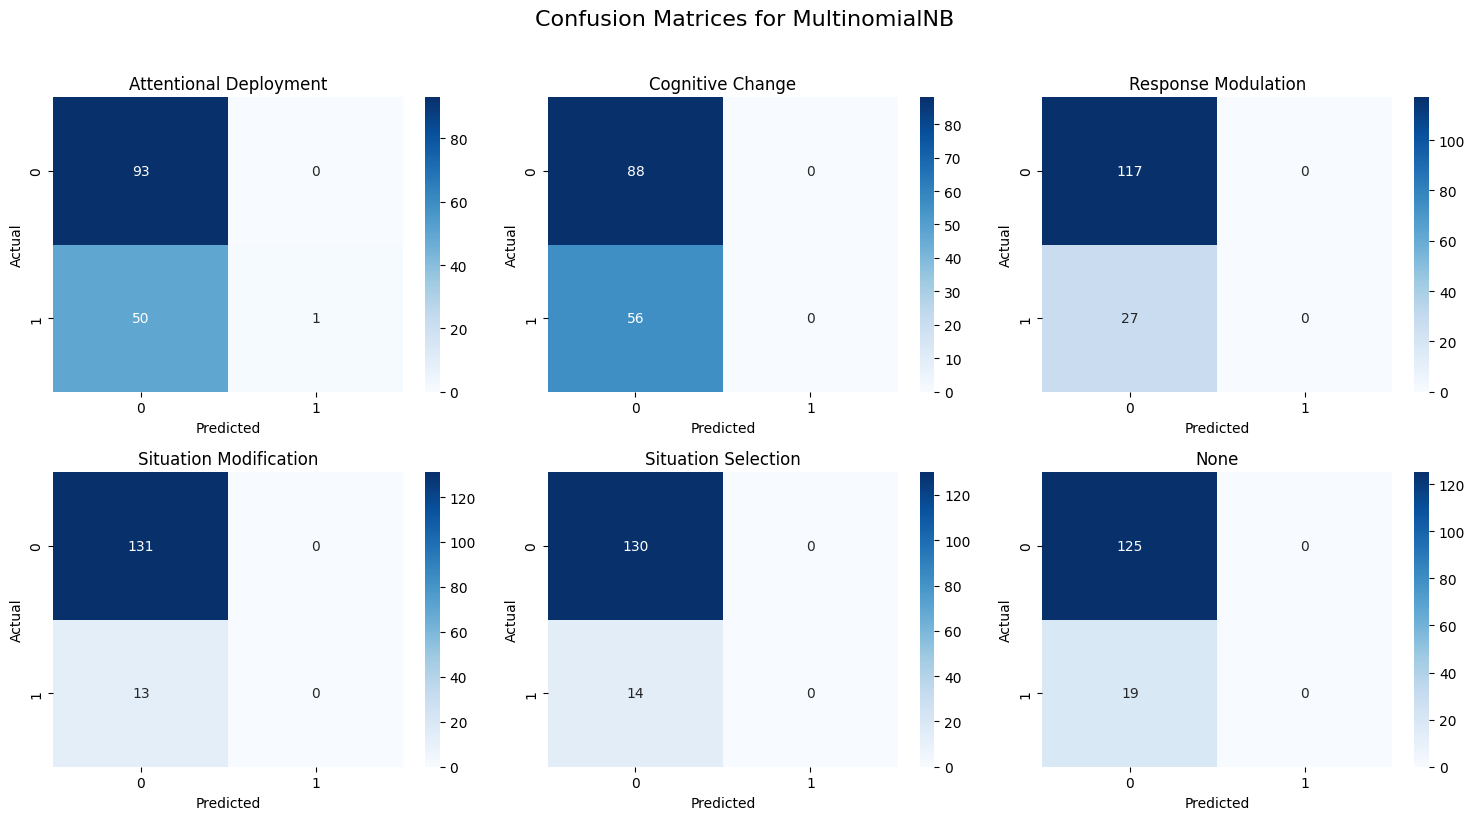


=== Evaluating KNN ===

DETAILED EVALUATION REPORT FOR KNeighborsClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6042     0.3750     0.1765     0.2400    
Cognitive Change          0.7014     0.6512     0.5000     0.5657    
Response Modulation       0.8125     0.0000     0.0000     0.0000    
Situation Modification    0.9097     0.0000     0.0000     0.0000    
Situation Selection       0.9028     0.0000     0.0000     0.0000    
None                      0.8681     0.0000     0.0000     0.0000    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.1528
Macro-Averaged Precision: 0.1343
Macro-Averaged Recall: 0.1343
Macro-Averaged F1-Score: 0.1343


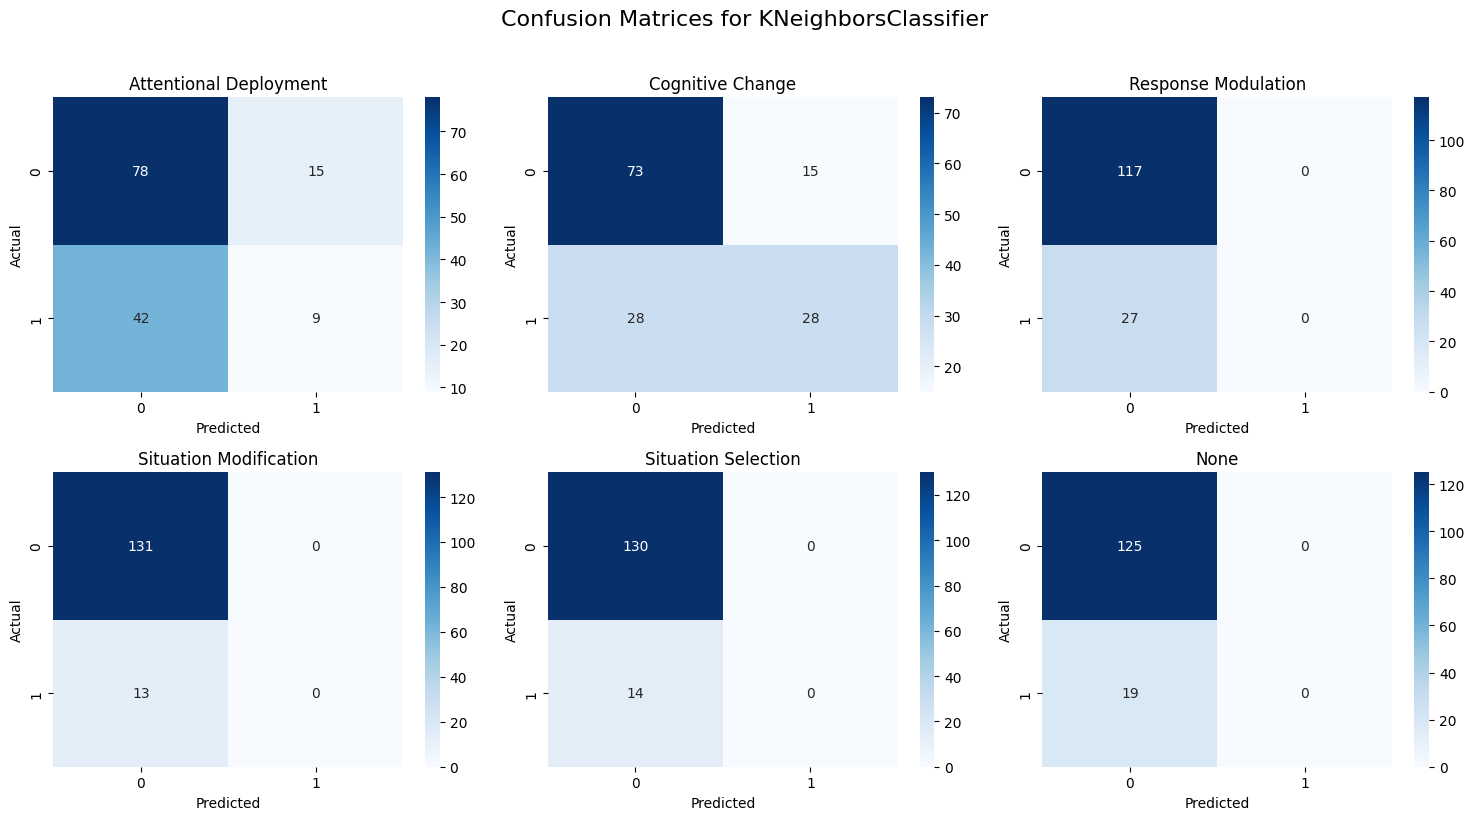


=== Evaluating DecisionTree ===

DETAILED EVALUATION REPORT FOR DecisionTreeClassifier

Category                  Accuracy   Precision  Recall     F1-Score  
-----------------------------------------------------------------
Attentional Deployment    0.6111     0.4561     0.5098     0.4815    
Cognitive Change          0.6597     0.6000     0.3750     0.4615    
Response Modulation       0.7153     0.2083     0.1852     0.1961    
Situation Modification    0.8542     0.0000     0.0000     0.0000    
Situation Selection       0.8542     0.2308     0.2143     0.2222    
None                      0.8750     0.5217     0.6316     0.5714    

--------------------------------------------------------------------------------
OVERALL MODEL PERFORMANCE
--------------------------------------------------------------------------------

Exact Match Accuracy: 0.1944
Macro-Averaged Precision: 0.3221
Macro-Averaged Recall: 0.3221
Macro-Averaged F1-Score: 0.3221


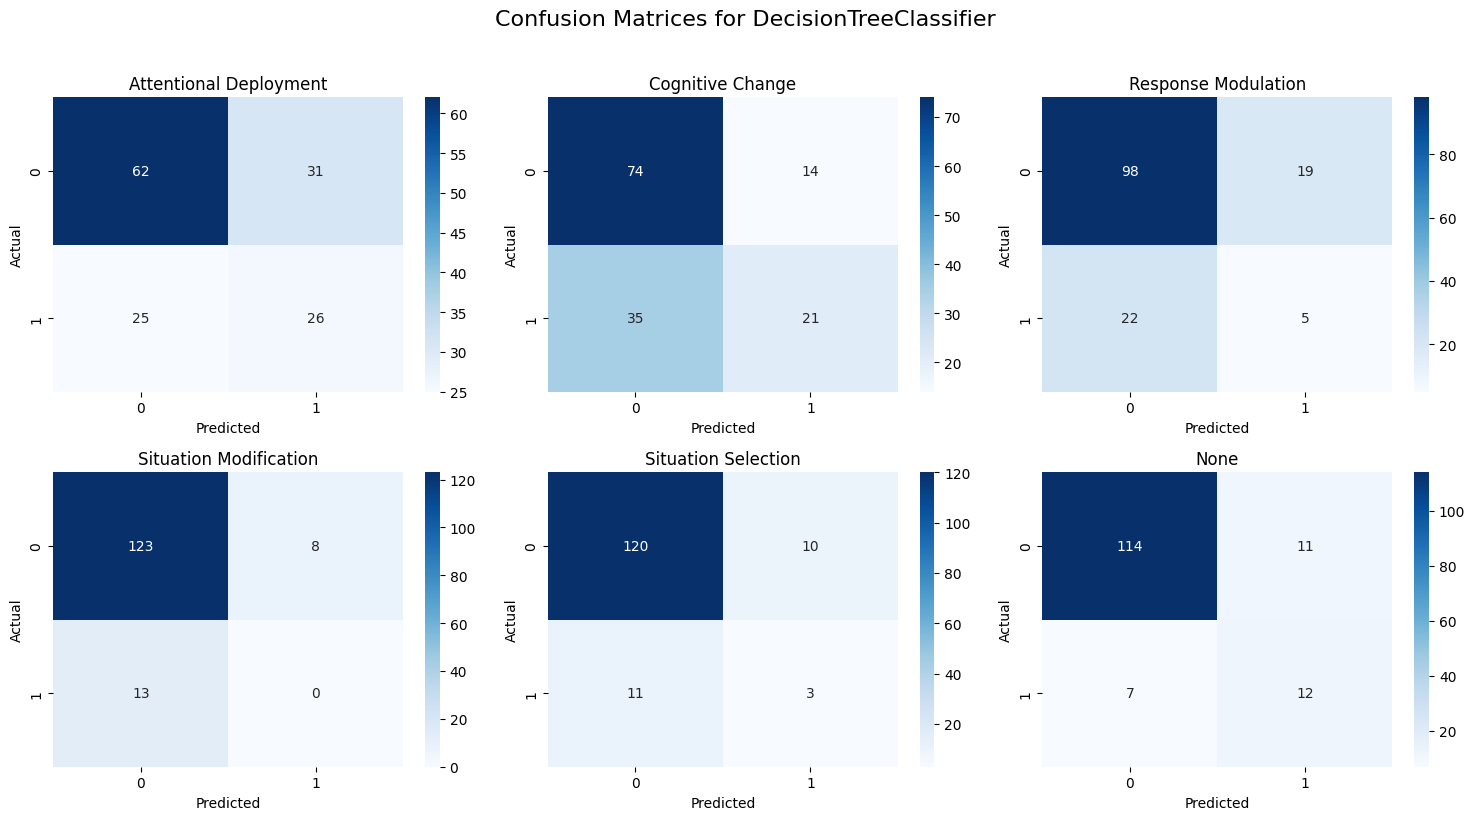


Generating overall performance visualizations...


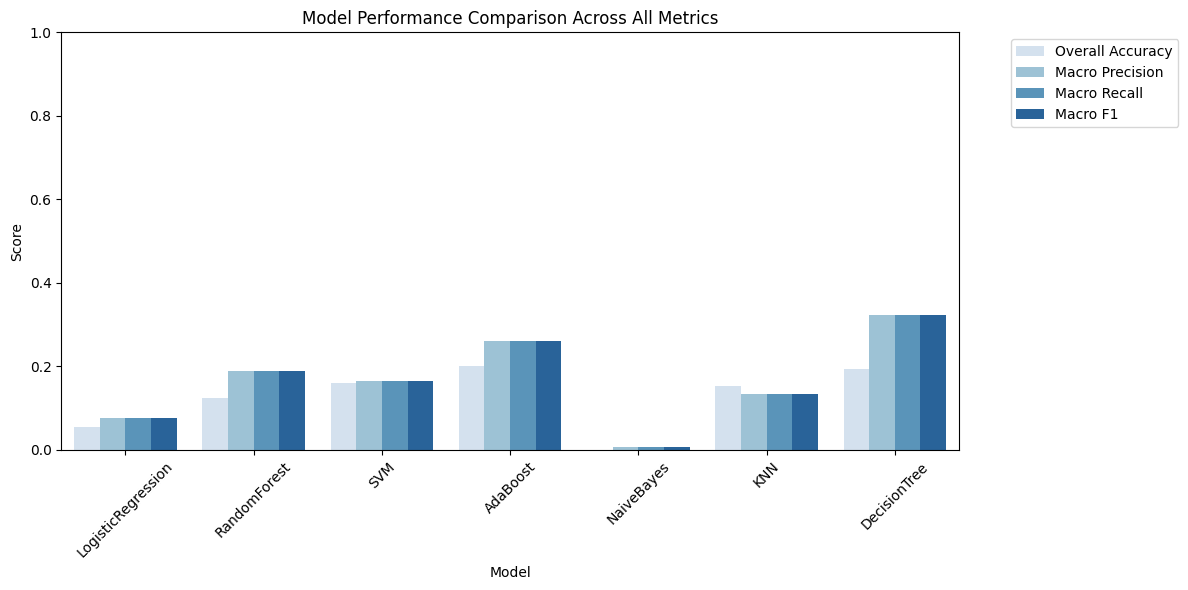


Generating per-category performance visualizations...


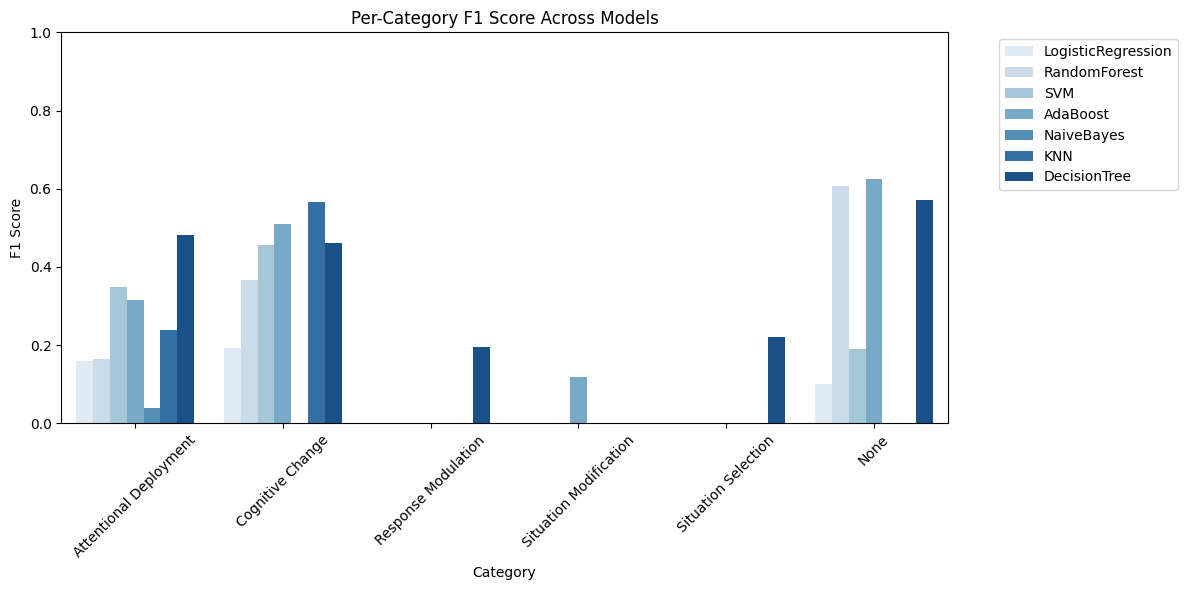

In [ ]:
def plot_per_category_model_comparison(results, categories):
    # Plot F1-scores for each model across different categories.

    # Prepare data for plotting
    metrics_data = {
        'Model': [],
        'Category': [],
        'F1 Score': []
    }

    # Populate data for each model and category
    for model_name, model_results in results.items():
        for category in categories:
            metrics_data['Model'].append(model_name)
            metrics_data['Category'].append(category)
            metrics_data['F1 Score'].append(model_results['category_f1_scores'].get(category, 0))

    # Convert data to DataFrame and plot
    df_metrics = pd.DataFrame(metrics_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_metrics, x='Category', y='F1 Score', hue='Model', palette='Blues')
    plt.title('Per-Category F1 Score Across Models')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # F1-score range
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_overall_model_comparison(results):
    # Plot overall performance metrics for all models in a grouped bar chart

    # Prepare a dictionary to hold performance metrics for each model
    metrics_data = {
        'Model': [],
        'Metric': [],
        'Score': []
    }

    # Populate the dictionary with scores for each model and metric
    for model_name, metrics in results.items():
        for metric in ['overall_accuracy', 'macro_precision', 'macro_recall', 'macro_f1']:
            metrics_data['Model'].append(model_name)
            metrics_data['Metric'].append(metric.replace('_', ' ').title())
            metrics_data['Score'].append(metrics[metric])

    df_metrics = pd.DataFrame(metrics_data)

    # Plot the grouped bar chart comparing models on various metrics
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_metrics, x='Model', y='Score', hue='Metric', palette='Blues')
    plt.title('Model Performance Comparison Across All Metrics')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def evaluate_model_across_categories(model, X, df, categories):
    # Split data into training and test sets
    X_train, X_test, df_train, df_test = train_test_split(X, df, test_size=0.3, random_state=42)

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=4000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Initialize predictions and confusion matrices
    all_predictions = np.zeros((len(X_test), len(categories)))
    all_true_labels = df_test[categories].values
    confusion_matrices = {}

    print(f"\n{'=' * 80}")
    print(f"DETAILED EVALUATION REPORT FOR {model.__class__.__name__}")
    print(f"{'=' * 80}")

    print(f"\n{'Category':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 65)

    category_f1_scores = {}

    # Evaluate performance for each category
    for idx, category in enumerate(categories):
        y_train = df_train[category]
        y_test = df_test[category]

        # Train the model and make predictions
        model.fit(X_train_vec, y_train)
        predictions = model.predict(X_test_vec)
        all_predictions[:, idx] = predictions

        # Get classification report and metrics for the category
        report = classification_report(y_test, predictions, output_dict=True)
        metrics = report['1'] if '1' in report else report['weighted avg']

        print(f"{category:<25} "
              f"{report['accuracy']:<10.4f} "
              f"{metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} "
              f"{metrics['f1-score']:<10.4f}")

        confusion_matrices[category] = confusion_matrix(y_test, predictions)
        category_f1_scores[category] = metrics['f1-score']

    print(f"\n{'-' * 80}")
    print("OVERALL MODEL PERFORMANCE")
    print(f"{'-' * 80}")

    # Calculate overall performance
    correct_predictions = np.all(all_predictions == all_true_labels, axis=1)
    overall_accuracy = np.mean(correct_predictions)

    macro_precision = np.mean([category_f1_scores[cat] for cat in categories])
    macro_recall = np.mean([category_f1_scores[cat] for cat in categories])
    macro_f1 = np.mean([category_f1_scores[cat] for cat in categories])

    print(f"\nExact Match Accuracy: {overall_accuracy:.4f}")
    print(f"Macro-Averaged Precision: {macro_precision:.4f}")
    print(f"Macro-Averaged Recall: {macro_recall:.4f}")
    print(f"Macro-Averaged F1-Score: {macro_f1:.4f}")

    # Plot confusion matrices for the model's predictions
    plot_confusion_matrices(confusion_matrices, categories, model.__class__.__name__)

    return {
        'overall_accuracy': overall_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'category_f1_scores': category_f1_scores,
        'confusion_matrices': confusion_matrices,
        'predictions': all_predictions
    }

def plot_confusion_matrices(confusion_matrices, categories, model_name):
    # Define the grid size for plotting confusion matrices
    n_categories = len(categories)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols

    # Create a figure for confusion matrices
    plt.figure(figsize=(15, 4 * n_rows))
    plt.suptitle(f'Confusion Matrices for {model_name}', fontsize=16, y=1.02)

    # Loop through each category and plot its confusion matrix
    for idx, (category, cm) in enumerate(confusion_matrices.items()):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{category}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

try:
    categories = ['Attentional Deployment', 'Cognitive Change', 'Response Modulation', 'Situation Modification', 'Situation Selection', 'None']
    df['None'] = np.where(df[categories[:-1]].sum(axis=1) == 0, 1, 0)
    X = df['text_cleaned']

    models = {
        "LogisticRegression": LogisticRegression(max_iter=3000),
        "RandomForest": RandomForestClassifier(random_state=42),
        "SVM": SVC(kernel="linear", probability=True),
        "AdaBoost": AdaBoostClassifier(n_estimators=100),
        "NaiveBayes": MultinomialNB(),
        "KNN": KNeighborsClassifier(n_neighbors=15),
        "DecisionTree": DecisionTreeClassifier(),
    }

    results = {}
    for model_name, model in models.items():
        print(f"\n=== Evaluating {model_name} ===")
        evaluation_results = evaluate_model_across_categories(model, X, df, categories)
        results[model_name] = evaluation_results

    print("\nGenerating overall performance visualizations...")
    plot_overall_model_comparison(results)

    print("\nGenerating per-category performance visualizations...")
    plot_per_category_model_comparison(results, categories)

except Exception as e:
    print(f"Error in main script: {e}")
    traceback.print_exc()
